In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.simplefilter('ignore')
N_JOBS = -1
SEED = 2017

In [2]:
# Get data
print("File sizes : ")
for f in os.listdir("raw_data"):
    print(f.ljust(30) + str(round(os.path.getsize("raw_data/" + f) / 1000000, 2)) + "MB")

train = pd.read_csv("raw_data/train.csv")
test = pd.read_csv("raw_data/test.csv")

display(train.shape)
display(train.head())
display(test.shape)
display(test.head())


File sizes : 
sample_submission.csv         0.09MB
test.csv                      3.19MB
train.csv                     3.22MB


(4209, 378)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.810,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.530,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.260,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.620,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.020,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


(4209, 377)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [3]:
# Check for duplicate ids
idsUniqueTrain = len(set(train.ID))
idsTotalTrain = train.shape[0]
idsDupliTrain = idsTotalTrain - idsUniqueTrain
print("There are " + str(idsDupliTrain) + " duplicate IDs for " + str(idsTotalTrain) + " total entries in Train")
idsUniqueTest = len(set(test.ID))
idsTotalTest = test.shape[0]
idsDupliTest = idsTotalTest - idsUniqueTest
print("There are " + str(idsDupliTest) + " duplicate IDs for " + str(idsTotalTest) + " total entries in Test")

There are 0 duplicate IDs for 4209 total entries in Train
There are 0 duplicate IDs for 4209 total entries in Test


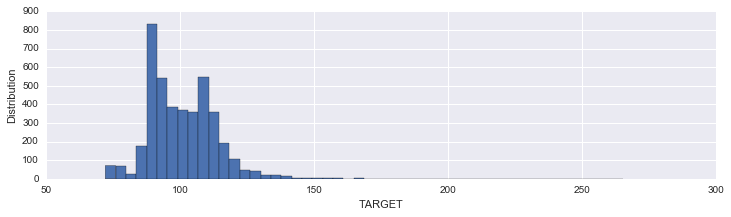

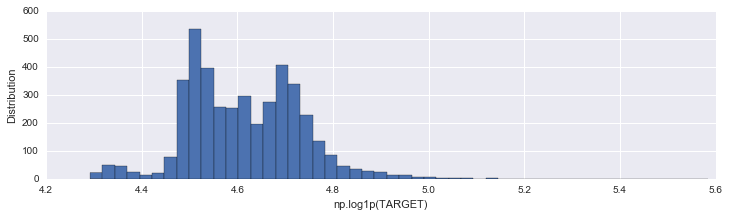

In [4]:
# Looking at the target variable distribution
plt.figure(figsize = (12,3))
plt.hist(train.y, bins = 50)
plt.xlabel("TARGET")
plt.ylabel("Distribution")
plt.show()
plt.figure(figsize = (12,3))
plt.hist(np.log1p(train.y), bins = 50)
plt.xlabel("np.log1p(TARGET)")
plt.ylabel("Distribution")
plt.show()
# TODO : test results with both targets

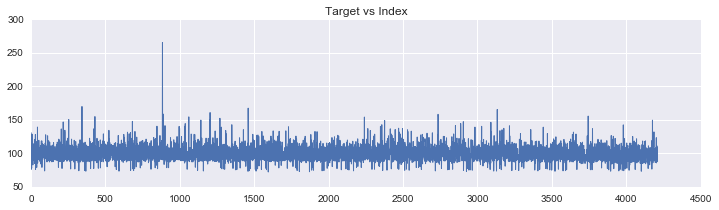

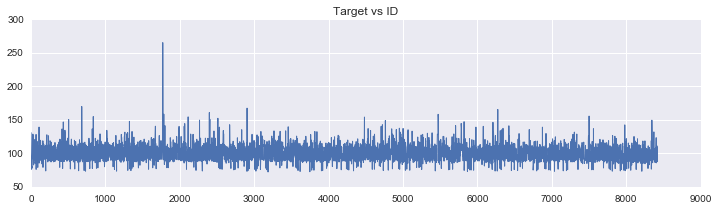

In [5]:
# Plot target vs index and ID
plt.figure(figsize = (12,3))
plt.plot(range(train.shape[0]), train.y, linewidth = 1)
plt.title("Target vs Index")
plt.show()
plt.figure(figsize = (12,3))
plt.plot(train.ID, train.y, linewidth = 1)
plt.title("Target vs ID")
plt.show()

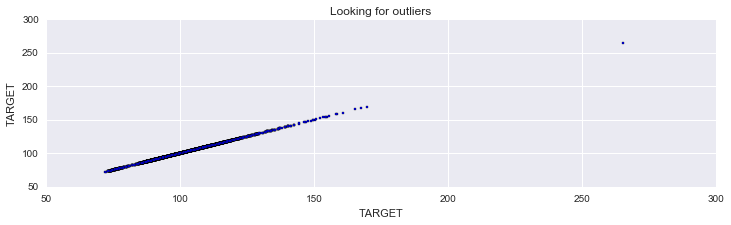

In [6]:
# Looking for outliers in the target variable 
plt.figure(figsize = (12,3))
plt.scatter(train.y, train.y, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers")
plt.xlabel("TARGET")
plt.ylabel("TARGET")
plt.show()
# TODO : test removal of biggest outlier

In [7]:
# Remove target from train set
target = train.y
train.drop("y", axis = 1, inplace = True)

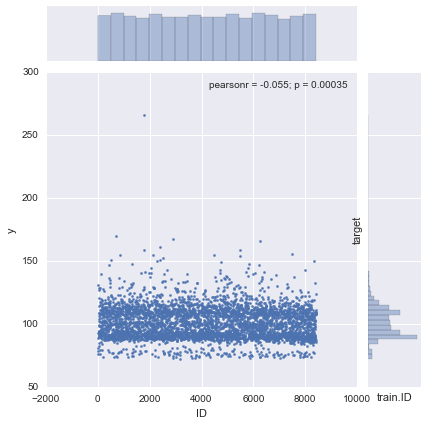

In [8]:
# Look for information in the id variable
sns.jointplot(x = train.ID, y = target, s = 5)
plt.xlabel("train.ID")
plt.ylabel("target")
plt.show()

In [9]:
# Concatenate train and test for global preprocessing
alldata = pd.concat([train, test], axis = 0)

In [10]:
# Look at missing values
print("Nb of NA in train + test : " + str(alldata.isnull().values.sum()))

Nb of NA in train + test : 0


In [11]:
# Check for constant variables (1 unique value in whole dataset)
old_nb_cols = alldata.shape[1]
alldata = alldata.loc[:, alldata.apply(pd.Series.nunique) != 1]
print("Removed constant columns : " + str(alldata.shape[1] - old_nb_cols))

Removed constant columns : 0


In [12]:
# Differentiate numerical features (minus the target) and categorical features
cat_feats = alldata.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(cat_feats)))
num_feats = alldata.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(num_feats)))

Categorical features : 8
Numerical features : 369


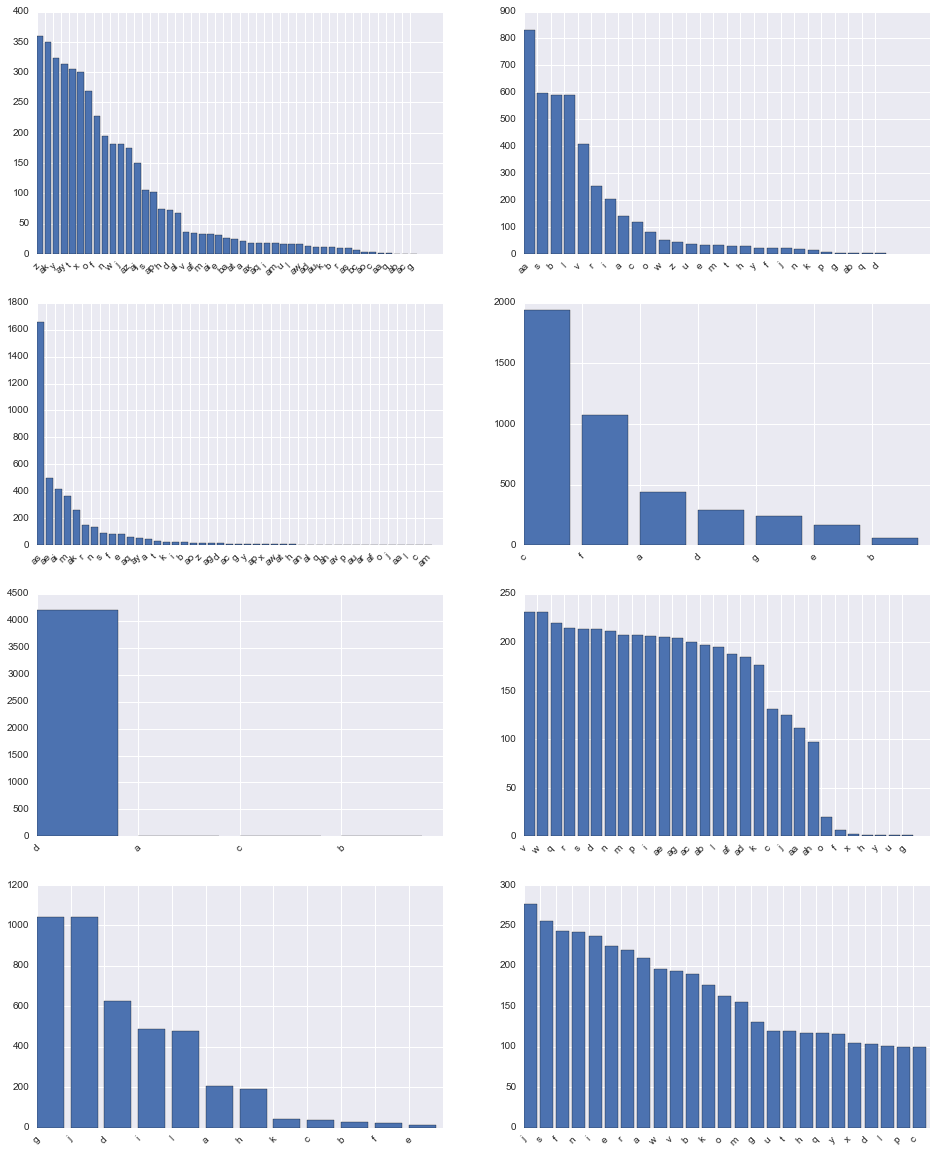

In [13]:
# Explore distribution of cat features
i = 0
fig, axs = plt.subplots(nrows = int(len(cat_feats) / 2), ncols = 2, figsize = (16, int(len(cat_feats) / 2) * 5))
for cat in cat_feats :
    value_counts = train[cat].value_counts()
    val_order = np.sort(train[cat].unique()).tolist()
    axs[int(i / 2), i % 2].bar(range(len(value_counts)), value_counts.values)
    axs[int(i / 2), i % 2].set_xticks(range(len(value_counts)))
    axs[int(i / 2), i % 2].set_xticklabels(value_counts.index, rotation = 45)
    i += 1
plt.show()

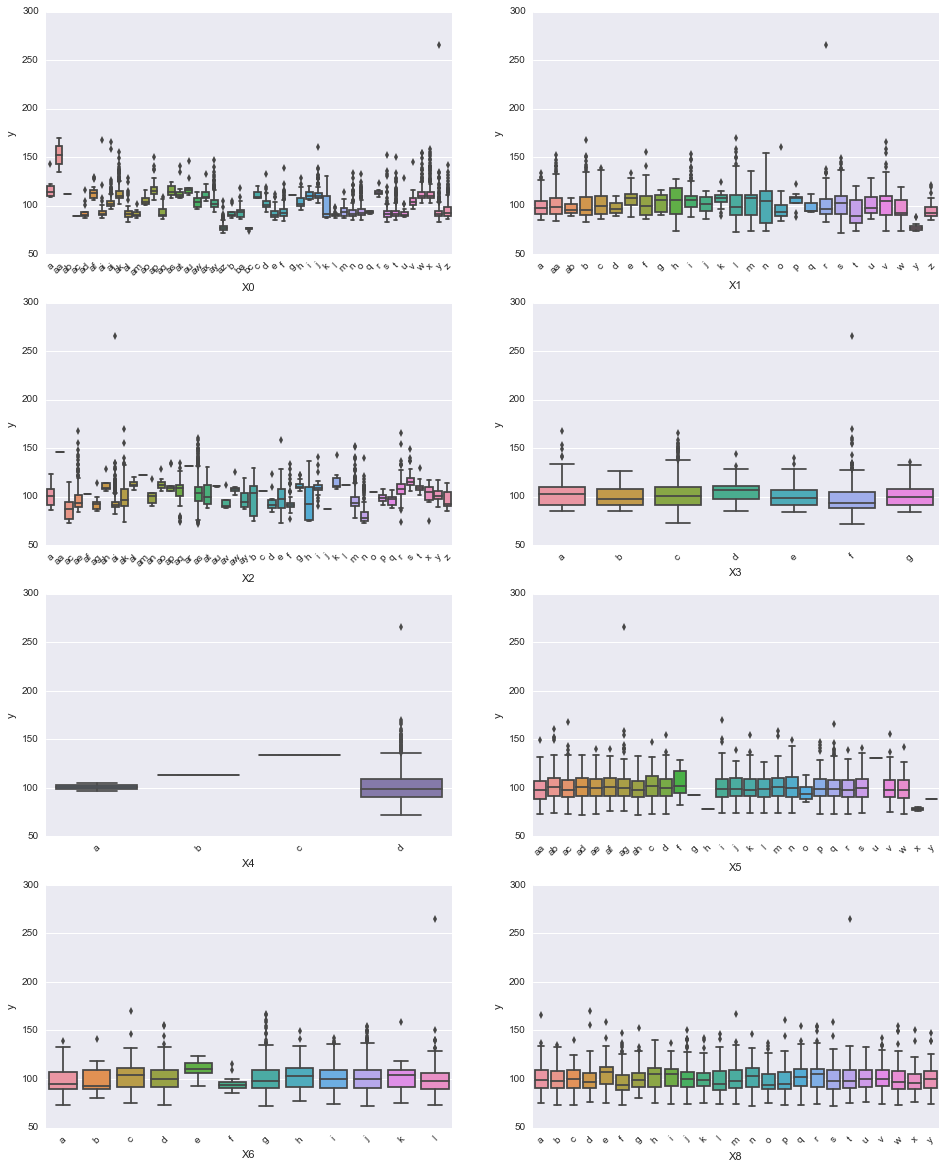

In [14]:
# Plot cat features vs target
i = 0
fig, axs = plt.subplots(nrows = int(len(cat_feats) / 2), ncols = 2, figsize = (16, int(len(cat_feats) / 2) * 5))
for cat in cat_feats :
    val_order = np.sort(train[cat].unique()).tolist()
    sns.boxplot(x = train[cat], y = target, order = val_order, ax = axs[int(i / 2), i % 2])
    axs[int(i / 2), i % 2].set_xticklabels(val_order, rotation = 45)
    i += 1
plt.show()

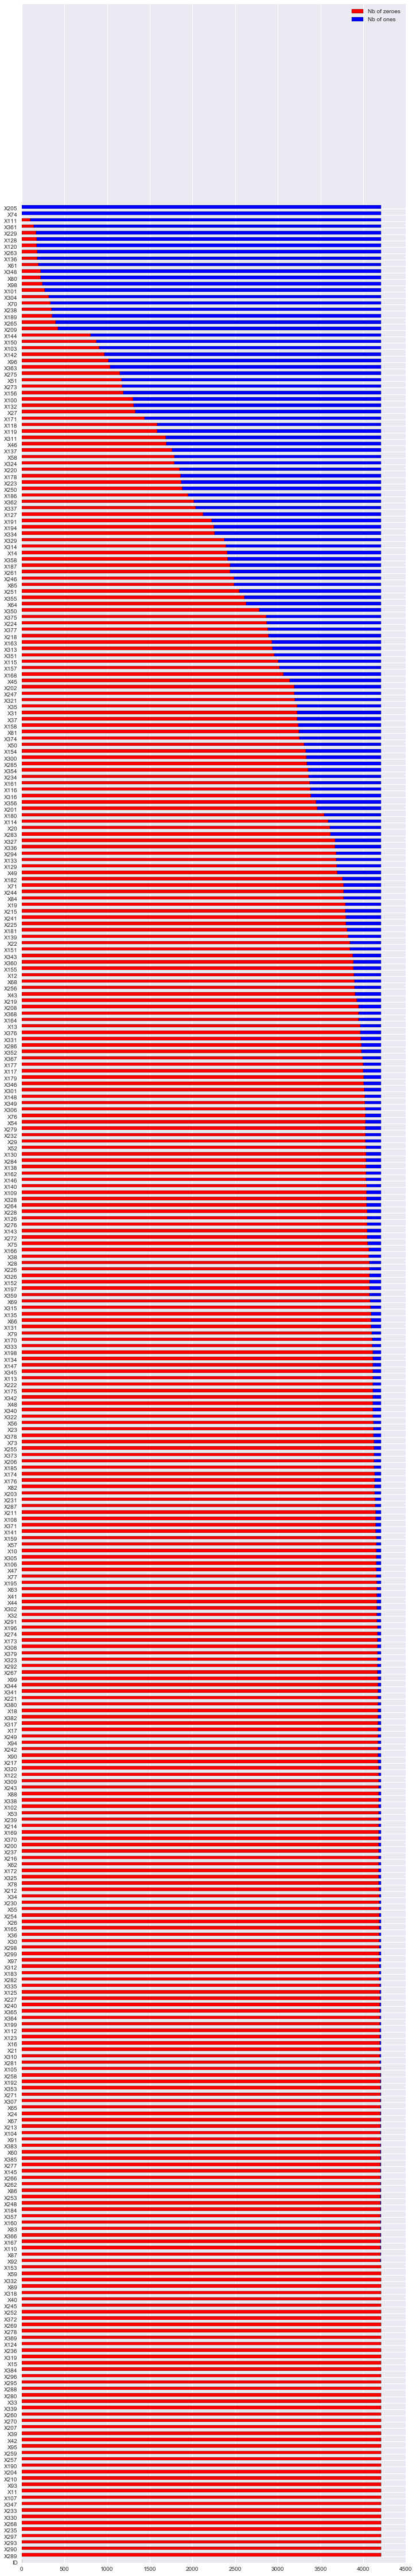

In [15]:
# Explore cardinality of binary features
zeroes = []
ones = []
for col in num_feats:
    zeroes.append((train[col] == 0).sum())
    ones.append((train[col] == 1).sum())

bin_feats = pd.DataFrame({"Label" : num_feats, 
                         "Zeroes" : zeroes, 
                         "Ones" : ones})
bin_feats.sort_values("Ones", ascending = True, inplace = True)
counts = np.arange(len(num_feats))

plt.figure(figsize=(12, 80))
p1 = plt.barh(counts, bin_feats.Zeroes, 0.5, color = "red")
p2 = plt.barh(counts, bin_feats.Ones, 0.5, left = bin_feats.Zeroes, color = "blue")
plt.yticks(counts, bin_feats.Label)
plt.legend((p1[0], p2[0]), ("Nb of zeroes", "Nb of ones"))
plt.show()

In [16]:
# Look at correlation between num features and target
temp_df = train[num_feats]
temp_df["y"] = target
corr = pd.Series(abs(temp_df.corr().y))
corr.sort_values(axis = 0, ascending = False, inplace = True)
display(corr.head(11))

y      1.000
X314   0.606
X261   0.589
X127   0.511
X263   0.380
X232   0.380
X29    0.380
X279   0.380
X54    0.368
X76    0.368
X136   0.368
Name: y, dtype: float64

In [17]:
# TODO : try operations betweens binary features : AND, OR
# TODO : try result of adding PCA/ICA components, one by one